# Erase Operator

In this example we demonstrate the capabilities of Erase operator and the different ways to specify its arguments.

The *Erase* operator can be used to remove parts of a tensor (e.g. an image) by specifying one or multiple regions together with a value to fill the erased regions.

Let's start with a simple case. In this pipeline we use the Erase operator to remove a rectangular region from the image by specifying the anchor and shape of the erased region in absolute coordinates

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 1
image_filename = 'images'

class ErasePipeline(Pipeline):                   
    def __init__(self, anchor, shape, axis_names, fill_value=0, normalized_anchor=False, normalized_shape=False, batch_size=1, num_threads=1, device_id=0):
        super(ErasePipeline, self).__init__(batch_size, num_threads, device_id, seed=1234)
        self.input_data = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.erase = ops.Erase(device="cpu", 
                               anchor=anchor, 
                               shape=shape, 
                               axis_names=axis_names, 
                               fill_value=fill_value,
                               normalized_anchor=normalized_anchor,
                               normalized_shape=normalized_shape)

    def define_graph(self):                                                                
        in_data, _ = self.input_data()
        images = self.decode(in_data)
        out = self.erase(images)        
        return out

We can now write a simple utility function to run and display the output of a pipeline instance

In [2]:
def show(pipe):
    pipe.build()
    out = pipe.run()
    plt.imshow(out[0].at(0))

We can now use the pipeline class to demostrate different use cases of the erase operator.

Lets start by specifying a rectangular region with of the image

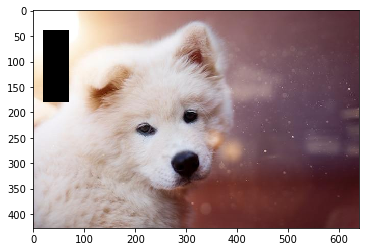

In [3]:
show(ErasePipeline(anchor=(40, 20), shape=(140, 50), axis_names="HW"))


The same region arguments could be interpreted differently if we change the value of *axis_names*

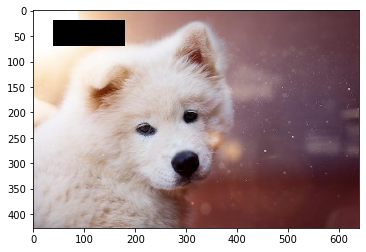

In [4]:
show(ErasePipeline(anchor=(40, 20), shape=(140, 50), axis_names="WH"))

We can specify a vertical or horizontal stripe by specifying only one dimension

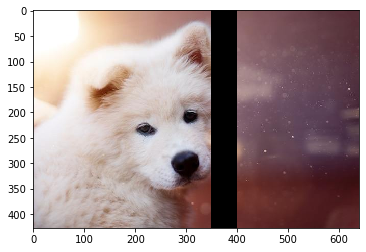

In [5]:
show(ErasePipeline(anchor=(350), shape=(50), axis_names="W"))

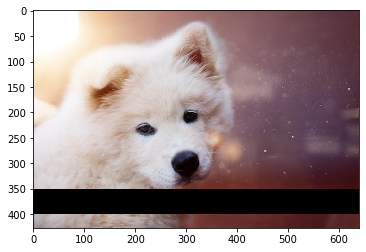

In [6]:
show(ErasePipeline(anchor=(350), shape=(50), axis_names="H"))

We can as well specifying multiple regions by adding more points to the *anchor* and *shape*the  arguments

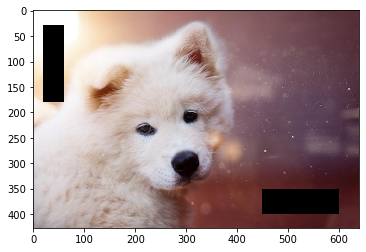

In [7]:
show(ErasePipeline(anchor=(30, 20, 350, 450), shape=(150, 40, 50, 150), axis_names="HW"))

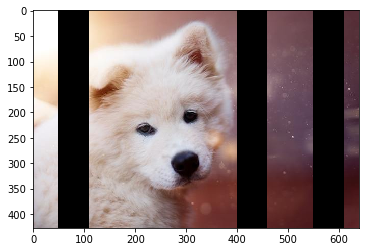

In [8]:
show(ErasePipeline(anchor=(50, 400, 550), shape=(60, 60, 60), axis_names="W"))

We can also change the default value for the erased regions

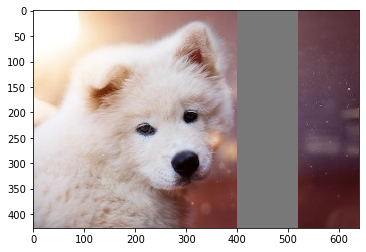

In [9]:
show(ErasePipeline(anchor=(400), shape=(120), axis_names="W", fill_value=120))

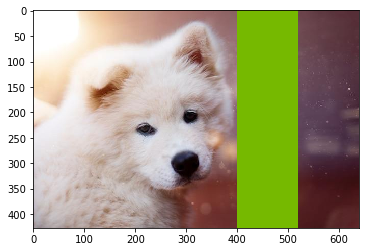

In [10]:
show(ErasePipeline(anchor=(400), shape=(120), axis_names="W", fill_value=(118, 185, 0)))

The region coordinates can be specified by relative coordinates as well. In that case, the relative coordinates will be multiplied by the input dimensions to obtain the absolute coordinates

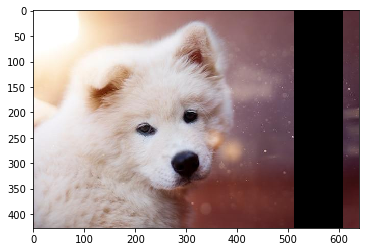

In [11]:
show(ErasePipeline(anchor=(0.8), shape=(0.15), axis_names="W", normalized_anchor=True, normalized_shape=True))

It is possible to use both relative and absolute coordinates to specify *anchor* and *shape* independently

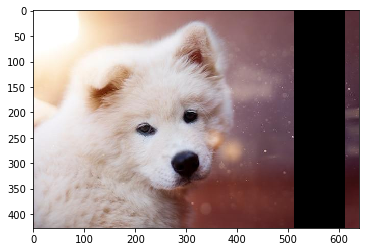

In [12]:
show(ErasePipeline(anchor=(0.8), shape=(100), axis_names="W", normalized_anchor=True, normalized_shape=False))

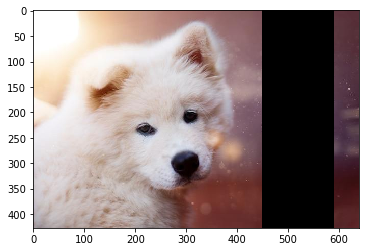

In [13]:
show(ErasePipeline(anchor=(450), shape=(0.22), axis_names="W", normalized_anchor=False, normalized_shape=True))

Last but not least, we can also use tensor inputs to specify the regions. For instance, we could use the output of a random number generator to feed the *anchor* and *shape* arguments of the *Erase* operator

In [20]:
class RandomErasePipeline(Pipeline):                   
    def __init__(self, batch_size=1, num_threads=1, device_id=0):
        super(RandomErasePipeline, self).__init__(batch_size, num_threads, device_id, seed=1234)
        self.input_data = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.random_anchor = ops.Uniform(range = (0., 1.))
        self.random_shape = ops.Uniform(range = (20., 150))
        self.erase = ops.Erase(device="cpu", 
                               axis_names="W", 
                               fill_value=(118, 185, 0),
                               normalized_anchor=True,
                               normalized_shape=False)

    def define_graph(self):                                                                
        in_data, _ = self.input_data()
        images = self.decode(in_data)
        out = self.erase(images, anchor=self.random_anchor(), shape=self.random_shape())        
        return out

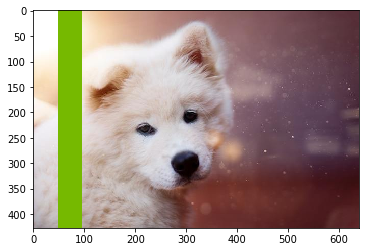

In [21]:
show(RandomErasePipeline())